### Analysis

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../../data/final/interaction-comb.csv')
data.head()

,condition_id,worker_id,type,granularity,true_pos,false_pos,true_neg,false_neg,accuracy,ppv,...,ViewControl_DoubleClick_total,ViewControl_MouseDown_per_pan_mean,ViewControl_MouseDown_per_pan_std,ViewControl_MouseDown_total,ViewControl_MouseUp_per_pan_mean,ViewControl_MouseUp_per_pan_std,ViewControl_MouseUp_total,WalkTowards_per_pan_mean,WalkTowards_per_pan_std,WalkTowards_total
0,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,10_meter,116,86,1564,54,0.923077,0.574257,...,137,2.395200,2.899322,1497,2.358400,2.775153,1474,0,0,0
1,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,5_meter,112,136,3262,74,0.941406,0.451613,...,137,2.395200,2.899322,1497,2.358400,2.775153,1474,0,0,0
2,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,street,76,18,140,4,0.907563,0.808511,...,137,2.395200,2.899322,1497,2.358400,2.775153,1474,0,0,0
3,70,A1DATRS7IUV9B3,turker,10_meter,120,110,1564,99,0.889593,0.521739,...,90,6.857143,7.531887,528,6.415584,6.701042,494,0,0,0
4,70,A1DATRS7IUV9B3,turker,5_meter,95,151,3264,132,0.922295,0.386179,...,90,6.857143,7.531887,528,6.415584,6.701042,494,0,0,0


In [4]:
print("num rows: ", len(data[data['granularity'] == 'street']))

num rows:  308


In [5]:
label_cols = data.columns[8:13].tolist()
print("labels:", label_cols)

feature_cols = data.columns[13:].tolist()
print("\nfeatures: ", feature_cols[:3], feature_cols[-3:])

labels: ['accuracy', 'ppv', 'npv', 'recall', 'specificity']

features:  ['Click_LabelDelete_per_pan_mean', 'Click_LabelDelete_per_pan_std', 'Click_LabelDelete_total'] ['WalkTowards_per_pan_mean', 'WalkTowards_per_pan_std', 'WalkTowards_total']


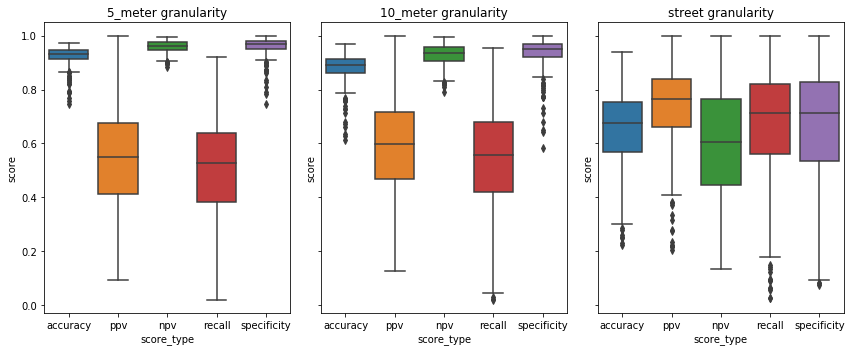

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

gran_types = ['5_meter', '10_meter', 'street']
fig, ax = plt.subplots(ncols=3, sharey=True)

for i, gran in enumerate(gran_types):
    labels = data[data.granularity == gran][label_cols] # labels with given granularity
    s = labels.stack().reset_index() # move all score types to one column
    s.columns = ['index', 'score_type', 'score']
    
    b = sns.boxplot(x=s['score_type'], y=s['score'], ax=ax[i])
    b.set_title(gran + ' granularity')
    
fig.set_size_inches(12,5)
fig.tight_layout()

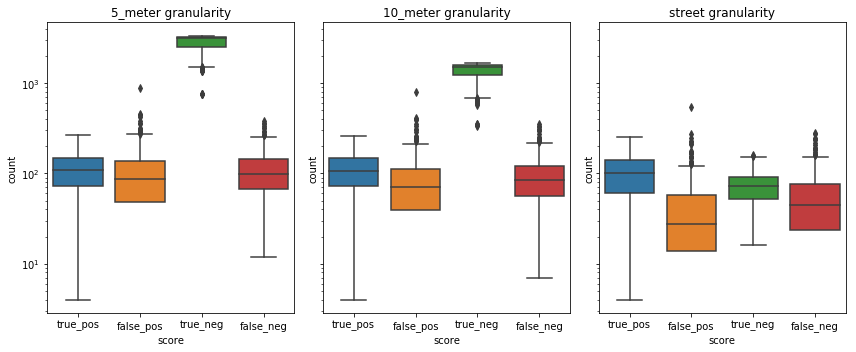

In [7]:
raw_score_cols = ['true_pos', 'false_pos', 'true_neg', 'false_neg']
fig, ax = plt.subplots(ncols=3, sharey=True)

for i, gran in enumerate(gran_types):
    labels = data[data.granularity == gran][raw_score_cols] # tp,fp,tn,fn for given granularity
    s = labels.stack().reset_index() # move all score types to one column
    s.columns = ['index', 'score', 'count']
    
    ax[i].set_yscale('log')
    b = sns.boxplot(x=s['score'], y=s['count'], ax=ax[i])
    b.set_title(gran + ' granularity')
    
fig.set_size_inches(12,5)
fig.tight_layout()

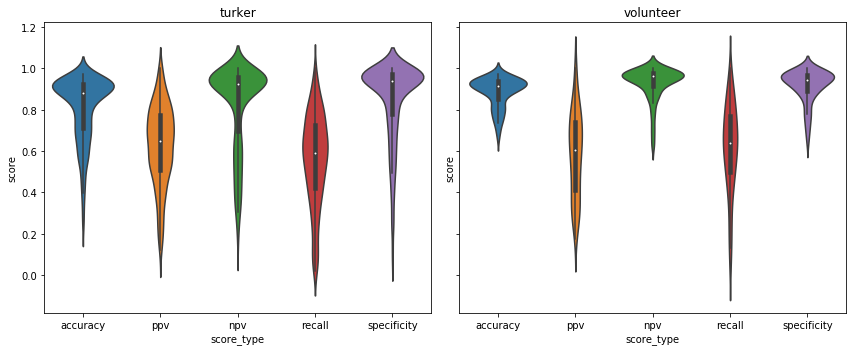

In [8]:
fig, ax = plt.subplots(ncols=2, sharey=True)

for i, worker_type in enumerate(['turker', 'volunteer']):
    labels = data[data.type == worker_type][label_cols] # labels from given worker type
    s = labels.stack().reset_index() # move all score types to one column
    s.columns = ['index', 'score_type', 'score']
    
    b = sns.violinplot(x=s['score_type'], y=s['score'], ax=ax[i])
    b.set_title(worker_type)
    
fig.set_size_inches(12,5)
fig.tight_layout()

### Regression
#### SVM

Accuracy: 0.31 (+/- 0.20)


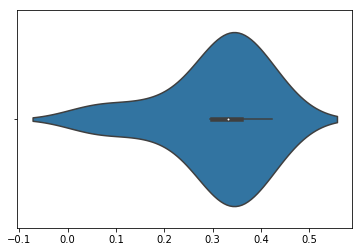

In [10]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

features = data[data.granularity == 'street'][feature_cols]
features = preprocessing.scale(features)

labels = data[data.granularity == 'street'][label_cols]['accuracy']

parameters = {'C': (0.01, 0.1, 1, 10, 100), 'epsilon': (0.000001, 0.0001, 0.001, 0.01, 0.1, 1)}

svr = svm.SVR()
clf = GridSearchCV(svr, parameters, n_jobs=-1)
scores = cross_val_score(clf, features, labels, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
sns.violinplot(x=scores)

#### Random Forrest Regressor

Accuracy: 0.49 (+/- 0.29)


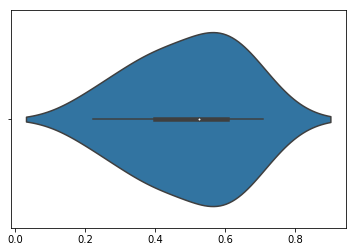

In [11]:
from sklearn.ensemble import RandomForestRegressor

features = data[data.granularity == 'street'][feature_cols]
features = preprocessing.scale(features)

labels = data[data.granularity == 'street'][label_cols]['accuracy']

parameters = {'n_estimators': (5, 10, 20, 40), 'max_features': ('auto', 'sqrt', 'log2')}

rfr = RandomForestRegressor()
clf = GridSearchCV(rfr, parameters, n_jobs=-1)
scores = cross_val_score(rfr, features, labels, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
sns.violinplot(x=scores)

#### AdaBoostRegressor

Accuracy: 0.53 (+/- 0.25)


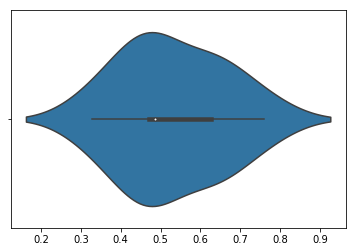

In [12]:
from sklearn.ensemble import AdaBoostRegressor

features = data[data.granularity == 'street'][feature_cols]
features = preprocessing.scale(features)

labels = data[data.granularity == 'street'][label_cols]['accuracy']

parameters = {}

rfr = AdaBoostRegressor(base_estimator=rfr)
clf = GridSearchCV(rfr, parameters, n_jobs=-1)
scores = cross_val_score(rfr, features, labels, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
sns.violinplot(x=scores)